This function takes in a list of blobs as x and y coordinates.
It tries to construct likely graphs connecting the blobs in a way that the match a pattern that could have been created by the electrodes. Each graph is assigned a likelyhood, and the best graph is returned.

/home/luhin/anaconda3/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/luhin/anaconda3/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/luhin/anaconda3/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/luhin/anaconda3/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


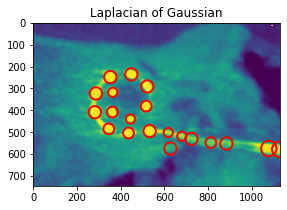

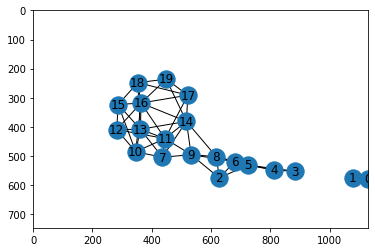

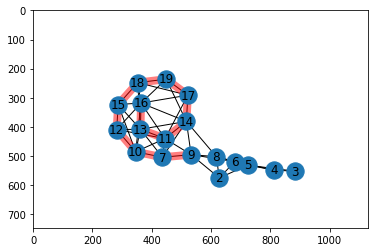

array([[  1., 364., 318.],
       [  2., 362., 408.],
       [  3., 445., 440.],
       [  4., 517., 381.],
       [  5., 522., 291.],
       [  6., 449., 236.],
       [  7., 353., 248.],
       [  8., 287., 323.],
       [  9., 282., 409.],
       [ 10., 346., 485.],
       [ 11., 436., 504.],
       [ 12., 533., 495.]])

In [178]:
from functions import *
from skimage.color import rgb2gray
import itertools
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

allpost, allpre, basenames = load("DATA")
blobs = get_blobs(allpost[1],20)

#max_angle=50
#angle_r=180-max_angle
#angle_l=180+max_angle

graph = nx.Graph()
graph.add_nodes_from(dict(enumerate(blobs)))

pos = {}
for i,blob in enumerate(blobs):
    graph.nodes[i]['pos'] = (blob[0],blob[1])
    pos.update({i:(blob[1],blob[0])})

#pairwise_combinations = list(itertools.combinations(blobs, 2))
pairwise_combinations = list(itertools.combinations(range(len(blobs)), 2))
for i, j in pairwise_combinations:
    blob_a = blobs[i]
    blob_b = blobs[j]
    dist = blob_dist(blob_a, blob_b)
    #if dist < 160 and dist > 90:
    if dist < 175 and dist > 60:
        graph.add_edge(i, j, length=dist)

        
draw_graph(graph,pos)
graph = remove_unconnected(graph)
#draw_graph(graph,pos)

paths = []

for node in graph.nodes():
    for neighbor in graph.neighbors(node):
        start = [node,neighbor]
        graph_new = graph.copy()
        graph_new.remove_node(node)
        solutions = get_next_possible_neigbours(graph, graph_new, start)
        for solution in solutions:
                paths.append(solution)

variances = [dist_var_of_path(blobs, path) for path in paths]
compactness = [2*path_compactness(blobs, path) for path in paths]

best_path_ind = path_likelihood(paths,blobs,variances,compactness)
path = paths[best_path_ind]
draw_graph_path(graph,pos,path,'red')
#path = paths[best_path_ind+2]
#draw_graph_path(graph,pos,path,'green')
#path = paths[best_path_ind+30]
#draw_graph_path(graph,pos,path,'yellow')
to_return = output(blobs,path)
to_return

In [170]:
basenames[1]

'ID37'

In [176]:
def output(blobs, path):
    
    coordinates = blobs[path,0:2]
    y_mean = np.mean(coordinates[:,0])
    x_mean = np.mean(coordinates[:,1])
    
    node_f = distance(blobs[path[0]][0:2],(y_mean,x_mean))
    node_l = distance(blobs[path[-1]][0:2],(y_mean,x_mean))
    
    #electrode 1 is innermost, electrode 12 is outermost
    if node_f > node_l: #if first node is further away from center of mass
        #flip the order of electrodes
        path = np.flip(path)
    output = np.zeros((12,3))
    output[:,0] = range(1,13)
    for i, elect in enumerate(path):
        y,x,sigma=blobs[elect]
        output[i,1] = x
        output[i,2] = y 
    return output
    

In [166]:
def path_likelihood(path,blobs,variances,compactness):
    mat = np.zeros((len(variances),2)) #shape (n_samples, n_features)
    mat[:,0]= variances
    mat[:,1]=compactness
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit(mat)    
    mat = scaler.transform(mat)
    variances = mat[:,0]
    compactness = mat[:,1]
    
    # argmin(sqrt(var^2+compactness^2))
    variances_2 = np.square(variances)
    compactness_2 = np.square(compactness)
    combined = np.sqrt(np.add(variances_2,compactness_2))
    best_path = np.argmin(combined)
    
    #plt.scatter(variances,compactness)
    #plt.scatter(variances[best_path],compactness[best_path],c='red')
    #plt.title("Feature distribution of all viable paths found")
    #plt.xlabel("Variance of electrode distances")
    #plt.ylabel("Compactness of electrode layout")
    #plt.show()    
    return best_path

In [36]:
def angle_difference(path,blobs):
    for n in range(len(path)-2):
        blob1 = blobs[n,:]
        blob2 = blobs[n+1,:]
        blob3 = blobs[n+2,:]
        this_angle = blob_angle(blob1, blob2, blob3)
        print(this_angle)

In [12]:
def get_next_possible_neigbours(graph_full, graph_left, path_chosen):
    #graph_full: the whole graph
    #graph_left: the part of the graph that is still available
    #path_chosen: list of nodes that make up this path: [starting node, ... , end node]
    if len(path_chosen)==12:
        #print(path_chosen)
        return [path_chosen]
    #[n for n in graph.neighbors(start[-1])]
    #print(path_chosen)
    paths_chosen = []
    #paths_chosen = path_chosen.copy()
    for neighbor in graph_left.neighbors(path_chosen[-1]):
        blob1 = blobs[neighbor,:]
        blob2 = blobs[path_chosen[-1],:]
        blob3 = blobs[path_chosen[-2],:]
        this_angle = blob_angle(blob1, blob2, blob3)
        if this_angle < 85:            
            #we've found a possible neighbor!
            new_graph_full = graph_full.copy()
            new_graph_left = graph_left.copy()
            new_graph_left.remove_node(path_chosen[-1])
            new_path_chosen = path_chosen.copy()
            new_path_chosen.append(neighbor)
            #call the function recursively with the updated path
            recursive_return = get_next_possible_neigbours(new_graph_full, new_graph_left, new_path_chosen)
            for solution in recursive_return:
                paths_chosen.append(solution)
    return paths_chosen
            

In [11]:
def path_compactness(blobs, path):
    coordinates = blobs[path,0:2]
    x_mean = np.mean(coordinates[:,0])
    y_mean = np.mean(coordinates[:,1])
    distances = [distance((x_mean,y_mean), node) for node in coordinates]
    return np.sum(distances)

In [10]:
def dist_var_of_path(blobs, path):
    dists = []
    route_edges = [(path[n],path[n+1]) for n in range(len(path)-1)]
    for a,b in route_edges:
        dists.append(blob_dist(blobs[a,:],blobs[b,:]))
    return np.var(dists)    

In [9]:
blob1 = blobs[10,:]
blob2 = blobs[13,:]
blob3 = blobs[14,:]
blob_angle(blob1, blob2, blob3)
#[(path[n],path[n+1]) for n in range(len(path)-1)]

NameError: name 'blobs' is not defined

In [8]:
def remove_unconnected(graph):
    #removes subgraphs that have <12 nodes as they cannot be our electrodes
    components_generator = nx.connected_components(graph)
    components = [graph.subgraph(c).copy() for c in components_generator]
    for component in components:
        if len(component)<12:
            graph.remove_nodes_from(component.nodes)
    return graph
    #draw_graph(S[0],pos)

In [138]:
def draw_graph(graph,pos):
    ax = plt.figure().gca()
    ax.set_axis_on()
    ax.set_ylim([746,0])
    ax.set_xlim([0,1129])
    nx.draw_networkx(graph,pos, ax=ax)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    #nx.draw_planar(graph)
    plt.show()

In [122]:
def draw_graph_path(graph,pos,path,color):
    route_edges = [(path[n],path[n+1]) for n in range(len(path)-1)]
    ax = plt.figure().gca()
    ax.set_axis_on()
    ax.set_ylim([746,0])
    ax.set_xlim([0,1129])
    nx.draw_networkx(graph,pos, ax=ax)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    #nx.draw_planar(graph)
    nx.draw_networkx_edges(graph, pos,
                       edgelist=route_edges,
                       width=8, alpha=0.5, edge_color=color)
    plt.show()

In [5]:
def blob_angle(blob1, blob2, blob3):
    x1, y1, r = blob1
    x2, y2, r = blob2
    x3, y3, r = blob3    
    v1_x = x2 - x1
    v1_y = y2 - y1
    v2_x = x3 - x2
    v2_y = y3 - y2    
    return angle((v1_x,v1_y),(v2_x,v2_y))

In [4]:
def blobs_in_range(center, blobs, max_range):
    #check which blobs are inside of range
    blobs_in_range = []
    for i, blob in enumerate(blobs):
        if dist(center,blob)<= max_range:
            blobs_in_range.append(i)
    return blobs_in_range
        

In [3]:
def blob_dist(blob1, blob2):
    return distance(blob1[0:2], blob2[0:2])

In [175]:
def get_blobs (image,nb_blobs):
    from skimage.feature import blob_log
    #returns list of Y,X coordinates and approximate radii of blobs detected
    #removes blobs that are far away until only nb_blobs are left (x and y are switched!!)
    
    image_gray = rgb2gray(image)

    #preprocessing: contrast stretching
    p2, p98 = np.percentile(image_gray, (2, 98))
    image_gray = exposure.rescale_intensity(image_gray, in_range=(p2, p98))


    #blob detection
    blobs_log = blob_log(image_gray, min_sigma = 15, max_sigma=25, num_sigma=5, threshold=.12)

    # comp approximated radii in the 3rd col
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    while len(blobs_log) > nb_blobs:
        distances = np.zeros((len(blobs_log), 2))
        for i, blob in enumerate(blobs_log):
            distances[i][0] = int(i)
            y1,x1,r = blob
            for n in range (i,len(blobs_log)):
                y2,x2, r = blobs_log[n]
                # draw.line((x1, y1, x2, y2), fill=128)
                dist = distance((x1,y1),(x2,y2))

                distances[i][1] += dist
                distances[n][1] += dist
        distances = distances[distances[:, 1].argsort()][:len(distances)]
        last = int(distances[len(distances)-1][0])
        #print(blobs_log)
        blobs_log = np.delete(blobs_log,last, axis=0)
        #print(blobs_log)
        #print(len(blobs_log))


    #display the blobs
    fig, ax = plt.subplots(1, 1, figsize=(9, 3), sharex=True, sharey=True)
    blobs = blobs_log
    title = 'Laplacian of Gaussian'
    ax.set_title(title)
    ax.imshow(image_gray)
    for blob in blobs_log:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
    plt.show()
    
    return blobs_log